# Import libraries

In [133]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_columns', None)

In [134]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input
The feature file `all_data.csv` is collected from [Jigsaw competition at Kaggle](https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/data?select=all_data.csv)

The result files are collected from the following notebooks
* [Tuning on Jigsaw unintended bias](https://www.kaggle.com/code/khairulislam/tuning-on-jigsaw-unintended-bias)
* [Private tuning on Jigsaw unintended bias](https://www.kaggle.com/code/khairulislam/private-tuning-on-jigsaw-unintended-bias)

In [135]:
data_root = '../data/'
results_root = '../results/'
df = pd.read_csv(os.path.join(data_root, 'all_data.csv'))

In [136]:
df['split'].value_counts()

train    1804875
test      194641
Name: split, dtype: int64

In [137]:
df.columns

Index(['id', 'comment_text', 'split', 'created_date', 'publication_id',
       'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes',
       'disagree', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
       'identity_attack', 'insult', 'threat', 'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability', 'identity_annotator_count',
       'toxicity_annotator_count'],
      dtype='object')

In [138]:
df['labels'] = df['toxicity'] >=0.5

In [139]:
df.groupby(['split'])[['labels']].value_counts()

split  labels
test   False      179193
       True        15448
train  False     1660541
       True       144334
dtype: int64

In [140]:
# other_gender didn't have any example 
genders = ['male', 'female', 'transgender']
# sexual_orientation = ['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']

races = ['black', 'white', 'asian','latino', 'other_race_or_ethnicity']
religions = ['christian', 'jewish', 'muslim', 'hindu','buddhist', 'atheist', 'other_religion']

# ability = ['physical_disability','intellectual_or_learning_disability', 
# 'psychiatric_or_mental_illness','other_disability']

In [141]:
# lr_rate =1e-3,batch_size=128, lr_scheduler
result = pd.read_csv(results_root + 'results.csv')

# lr_rate =1e-3,batch_size=128, max_physical_batch_size=64, lr_scheduler, noise_multiplier=0.2, delta=5e-2
result_dp = pd.read_csv(results_root + '/results_dp.csv')

# Preprocess

In [142]:
merged = result.merge(df, on=['id', 'split'], how='inner').reset_index(drop=True)
print(merged.shape)

merged_dp = result_dp.merge(df, on=['id', 'split'], how='inner').reset_index(drop=True)
print(merged_dp.shape)

(483309, 49)
(483309, 49)


In [143]:
identity_columns = genders

In [144]:
# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['toxicity'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

In [145]:
merged = convert_dataframe_to_bool(merged)
merged_dp = convert_dataframe_to_bool(merged_dp)

# Performance

## Metric utils
Implementation is collected from the [Jigsaw competition notebook](https://www.kaggle.com/code/dborkan/benchmark-kernel).
Descriptions are available at the [competition evaluation tab](https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation).

In [146]:
from sklearn import metrics

SUBGROUP_F1 = 'subgroup_f1'
SUBGROUP_ACCURACY = 'subgroup_accuracy'
SUBGROUP_AUC = 'subgroup_auc'
SUBGROUP_FPR = 'subgroup_fpr'
SUBGROUP_TPR = 'subgroup_tpr'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive
TOXICITY_COLUMN = 'toxicity'

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

# https://en.wikipedia.org/wiki/False_positive_rate

def calculate_FPR(df, label, model_name):
    y_pred = df[model_name]>=0.5
    false_positives = df[(y_pred) & (~df[label])].shape[0]
    negatives = df[~df[label]].shape[0]

    if negatives == 0:
        print("FPR is undefined. No negative examples found!")
        return np.nan
        
    return false_positives/negatives

def calculate_TPR(df, label, model_name):
    y_pred = df[model_name]>=0.5
    true_positives = df[(y_pred) & (df[label])].shape[0]
    positives = df[df[label]].shape[0]

    if positives == 0:
        print("TPR is undefined. No positive examples found!")
        return np.nan
        
    return true_positives/positives

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset, subgroups, model, label_col):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        subset = dataset[dataset[subgroup]]
        y_true, y_prob, y_pred = subset[label_col], subset[model], subset[model]>=0.5

        record[SUBGROUP_F1] = metrics.f1_score(y_true, y_pred)
        record[SUBGROUP_ACCURACY] = metrics.accuracy_score(y_true, y_pred)
        record[SUBGROUP_AUC] = metrics.roc_auc_score(y_true, y_prob)

        # https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        record[SUBGROUP_FPR] = calculate_FPR(subset, label_col, model)
        record[SUBGROUP_TPR] = calculate_TPR(subset, label_col, model)
        
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records)

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [147]:
def performance(df, split_type='test', prediction_column='probs'):
    df = df[df['split']==split_type]

    bias_metrics_df = compute_bias_metrics_for_model(
        df, identity_columns, prediction_column, TOXICITY_COLUMN
    )
    
    acc = metrics.accuracy_score(df[TOXICITY_COLUMN], df[prediction_column]>=0.5)
    f1 = metrics.f1_score(df[TOXICITY_COLUMN], df[prediction_column]>=0.5)
    auc = metrics.roc_auc_score(df[TOXICITY_COLUMN], df[prediction_column])

    final_bias = get_final_metric(bias_metrics_df, auc)
    final_fpr = calculate_FPR(df, TOXICITY_COLUMN, prediction_column)
    final_tpr = calculate_TPR(df, TOXICITY_COLUMN, prediction_column)

    TPED = abs(final_tpr - bias_metrics_df[SUBGROUP_TPR]).sum()
    FPED = abs(final_fpr - bias_metrics_df[SUBGROUP_FPR]).sum()

    print(f'Accuracy {np.round(acc, 4)}, F1 {np.round(f1,4)}, AUC {np.round(auc, 4)}, TPR {np.round(final_tpr, 4)}, FPR {np.round(final_fpr, 4)}.')
    print(f'Final bias {np.round(final_bias, 4)}. Eodds {np.round(TPED+FPED, 4)}, TPED {np.round(TPED, 4)}, FPED {np.round(FPED, 4)}.')
    
    return bias_metrics_df

## Normal

### Train

In [148]:
train_bias_metrics_df = performance(merged, 'train')
train_bias_metrics_df

Accuracy 0.8545, F1 0.856, AUC 0.9299, TPR 0.8651, FPR 0.1561.
Final bias 0.882. Eodds 0.7116, TPED 0.0571, FPED 0.6545.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,male,9992,0.861038,0.809247,0.867146,0.340490,0.883321,0.865778,0.935266
1,female,11341,0.844989,0.796931,0.863085,0.314888,0.858569,0.876115,0.927056
2,transgender,716,0.835061,0.755587,0.761860,0.467391,0.832707,0.820932,0.912010


### Test

In [149]:
test_bias_metrics_df = performance(merged, 'test')
test_bias_metrics_df

Accuracy 0.8532, F1 0.4904, AUC 0.9425, TPR 0.8898, FPR 0.1499.
Final bias 0.9095. Eodds 0.8555, TPED 0.1204, FPED 0.7351.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,male,4386,0.489438,0.707934,0.889294,0.329656,0.916418,0.888301,0.948003
1,female,5155,0.452318,0.718138,0.879292,0.304952,0.867052,0.898059,0.935209
2,transgender,260,0.455814,0.550000,0.858336,0.550239,0.960784,0.842248,0.957125


## Differential Private

### Train

In [150]:
train_dp_bias_metrics_df = performance(merged_dp, 'train')
train_dp_bias_metrics_df

Accuracy 0.8323, F1 0.8318, AUC 0.8984, TPR 0.8291, FPR 0.1645.
Final bias 0.8478. Eodds 0.7201, TPED 0.0587, FPED 0.6615.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,male,9992,0.849758,0.794636,0.831778,0.353795,0.868063,0.809445,0.917744
1,female,11341,0.831875,0.779737,0.827059,0.339206,0.845302,0.819832,0.909266
2,transgender,716,0.835849,0.756983,0.740009,0.461957,0.832707,0.752878,0.902247


### Test

In [151]:
test_dp_bias_metrics_df = performance(merged_dp, 'test')
test_dp_bias_metrics_df

Accuracy 0.8507, F1 0.4733, AUC 0.9175, TPR 0.8449, FPR 0.1488.
Final bias 0.8748. Eodds 0.8121, TPED 0.1395, FPED 0.6726.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,male,4386,0.481437,0.703830,0.857884,0.331539,0.900000,0.836971,0.936352
1,female,5155,0.450726,0.721048,0.853307,0.299350,0.852601,0.853436,0.923327
2,transgender,260,0.470000,0.592308,0.779623,0.488038,0.921569,0.795411,0.930415


In [152]:
diff = test_bias_metrics_df.drop(columns=['subgroup']) - test_dp_bias_metrics_df.drop(columns=['subgroup'])
diff['subgroup'] = test_bias_metrics_df['subgroup']
diff

,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc,subgroup
0,0,0.008001,0.004104,0.031409,-0.001884,0.016418,0.051329,0.011651,male
1,0,0.001592,-0.002910,0.025985,0.005602,0.014451,0.044623,0.011882,female
2,0,-0.014186,-0.042308,0.078713,0.062201,0.039216,0.046837,0.026711,transgender


## Plot
https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/

In [153]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = False
plt.rcParams["figure.dpi"] = 600

## Count

In [154]:
count_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Train': train_bias_metrics_df['subgroup_size'],
        'Test': test_bias_metrics_df['subgroup_size']
    }
)
count_df

,Identity,Train,Test
0,male,9992,4386
1,female,11341,5155
2,transgender,716,260


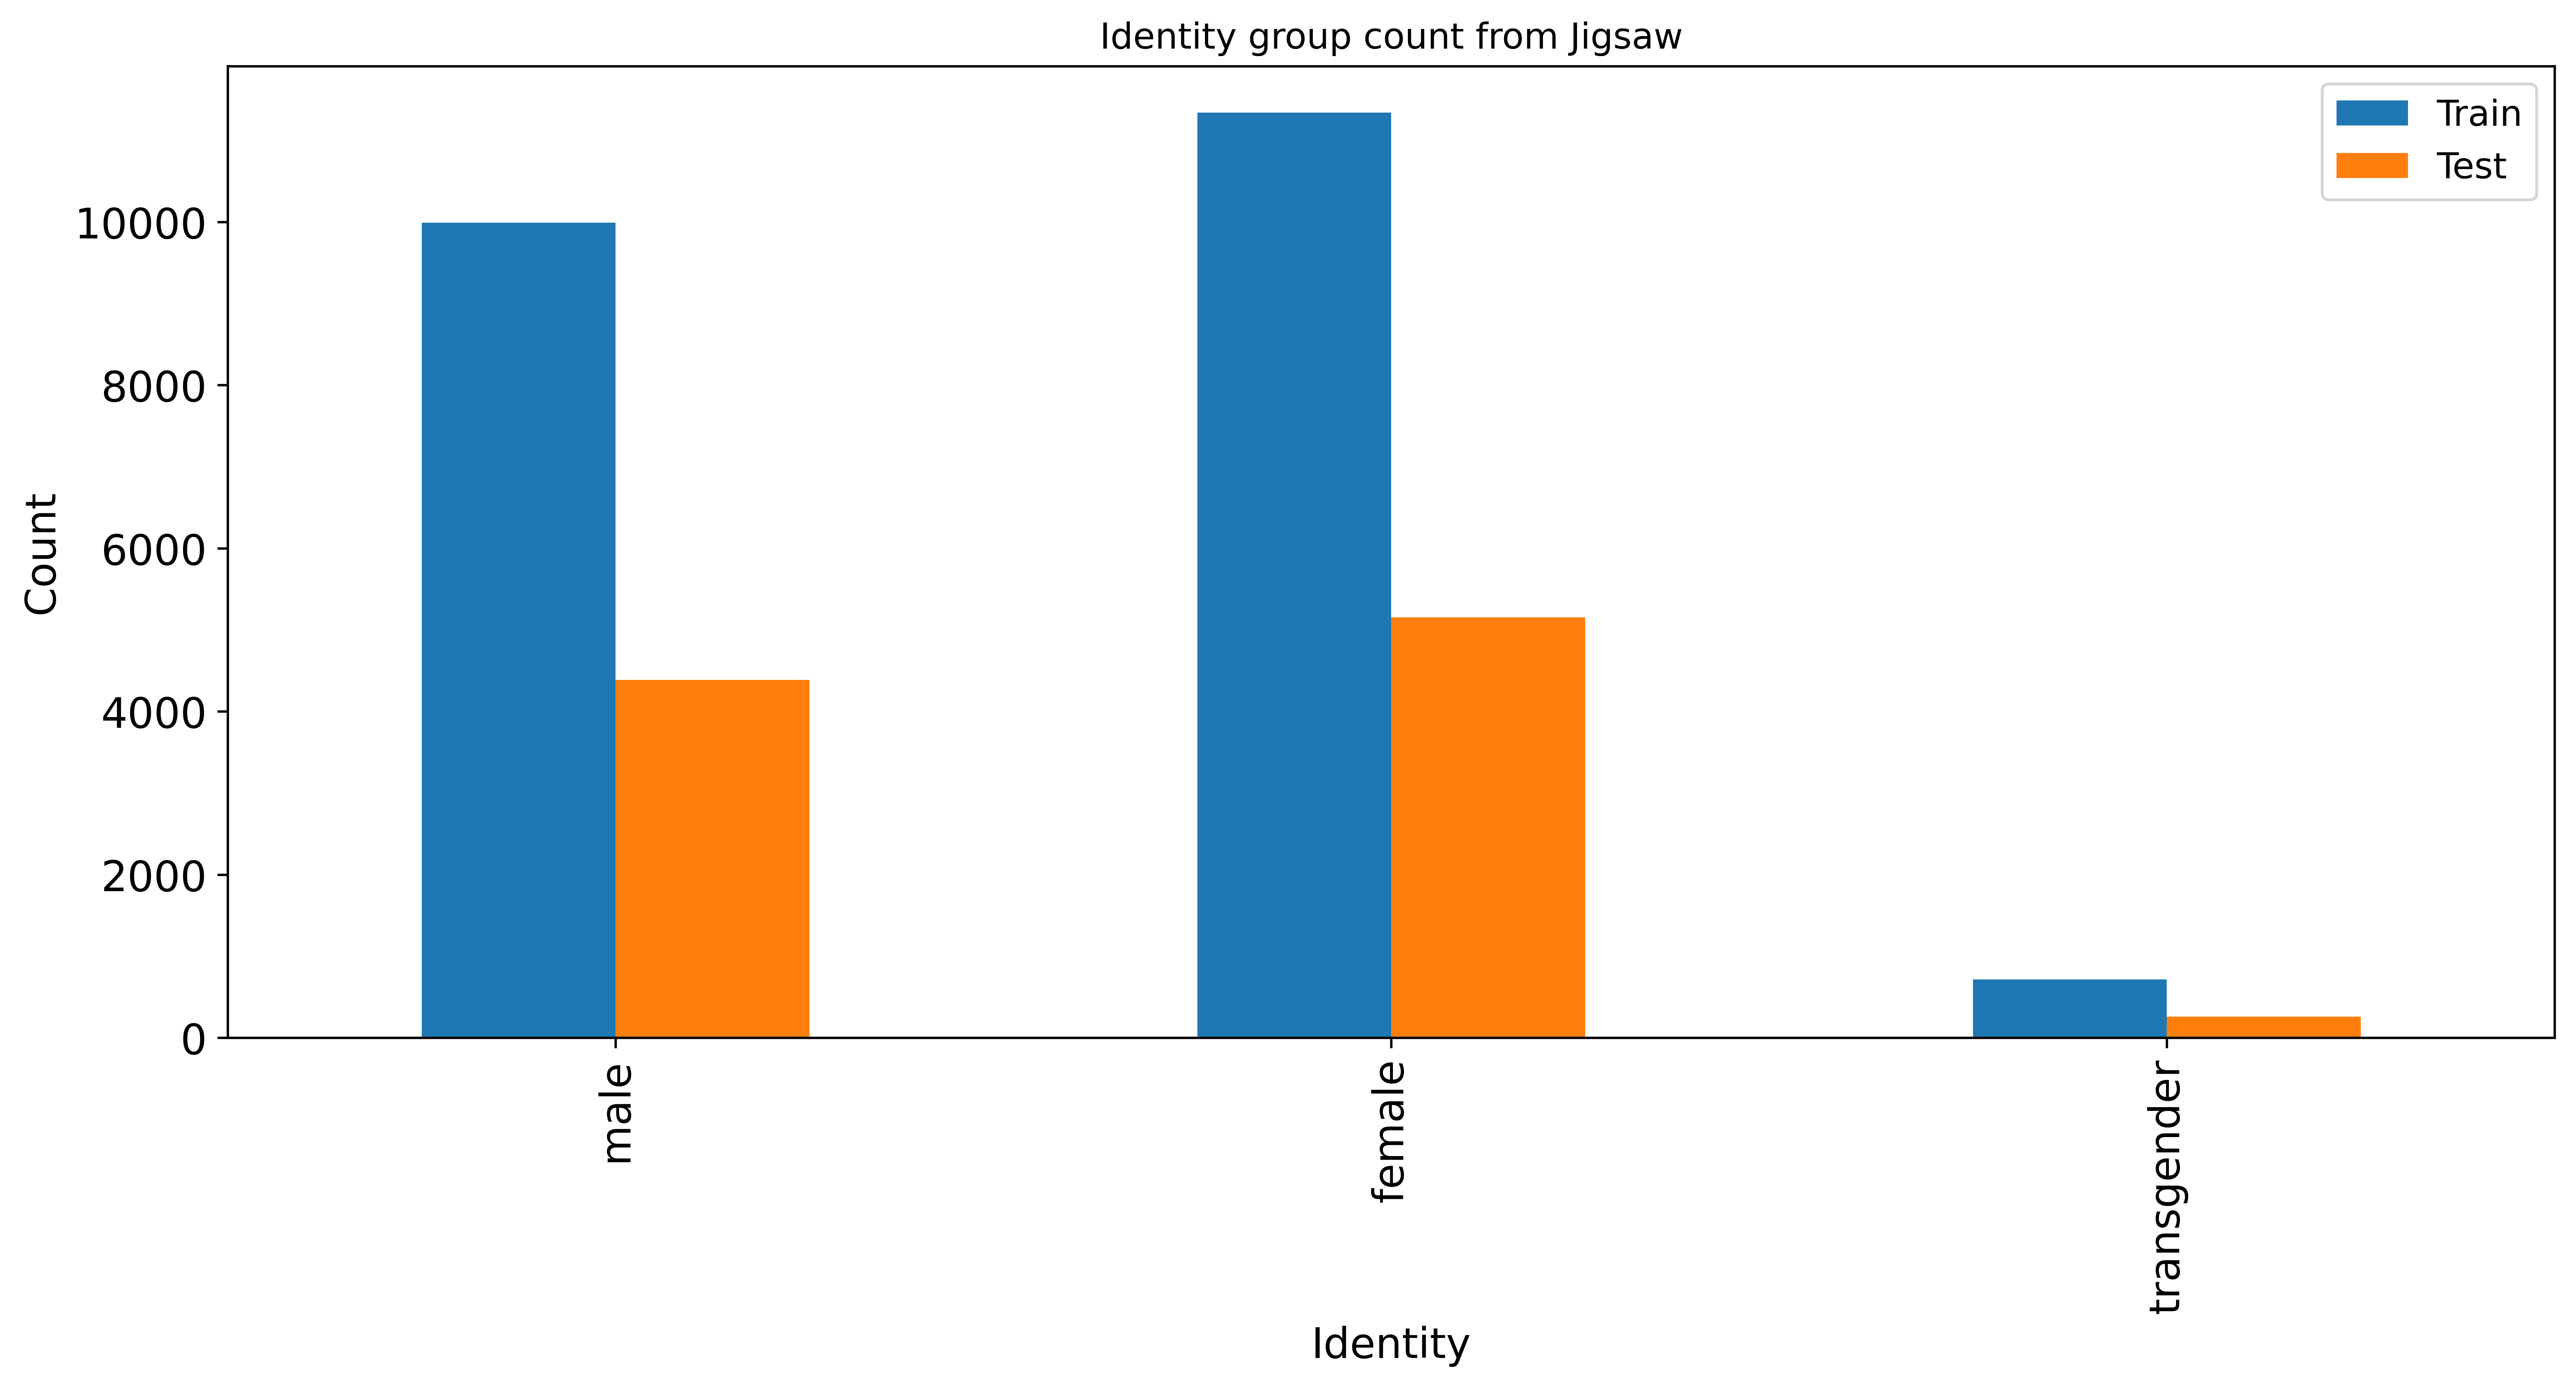

In [155]:
# plot grouped bar chart
ax = count_df.plot(
        x='Identity',
        kind='bar',
        stacked=False,
        title='Identity group count from Jigsaw',
        figsize=(14, 6),
        fontsize=14
)

ax.set_xlabel('Identity', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.legend(loc=1, fontsize=12)
plt.savefig(os.path.join(results_root, 'Count_plot.svg'))

## AUC

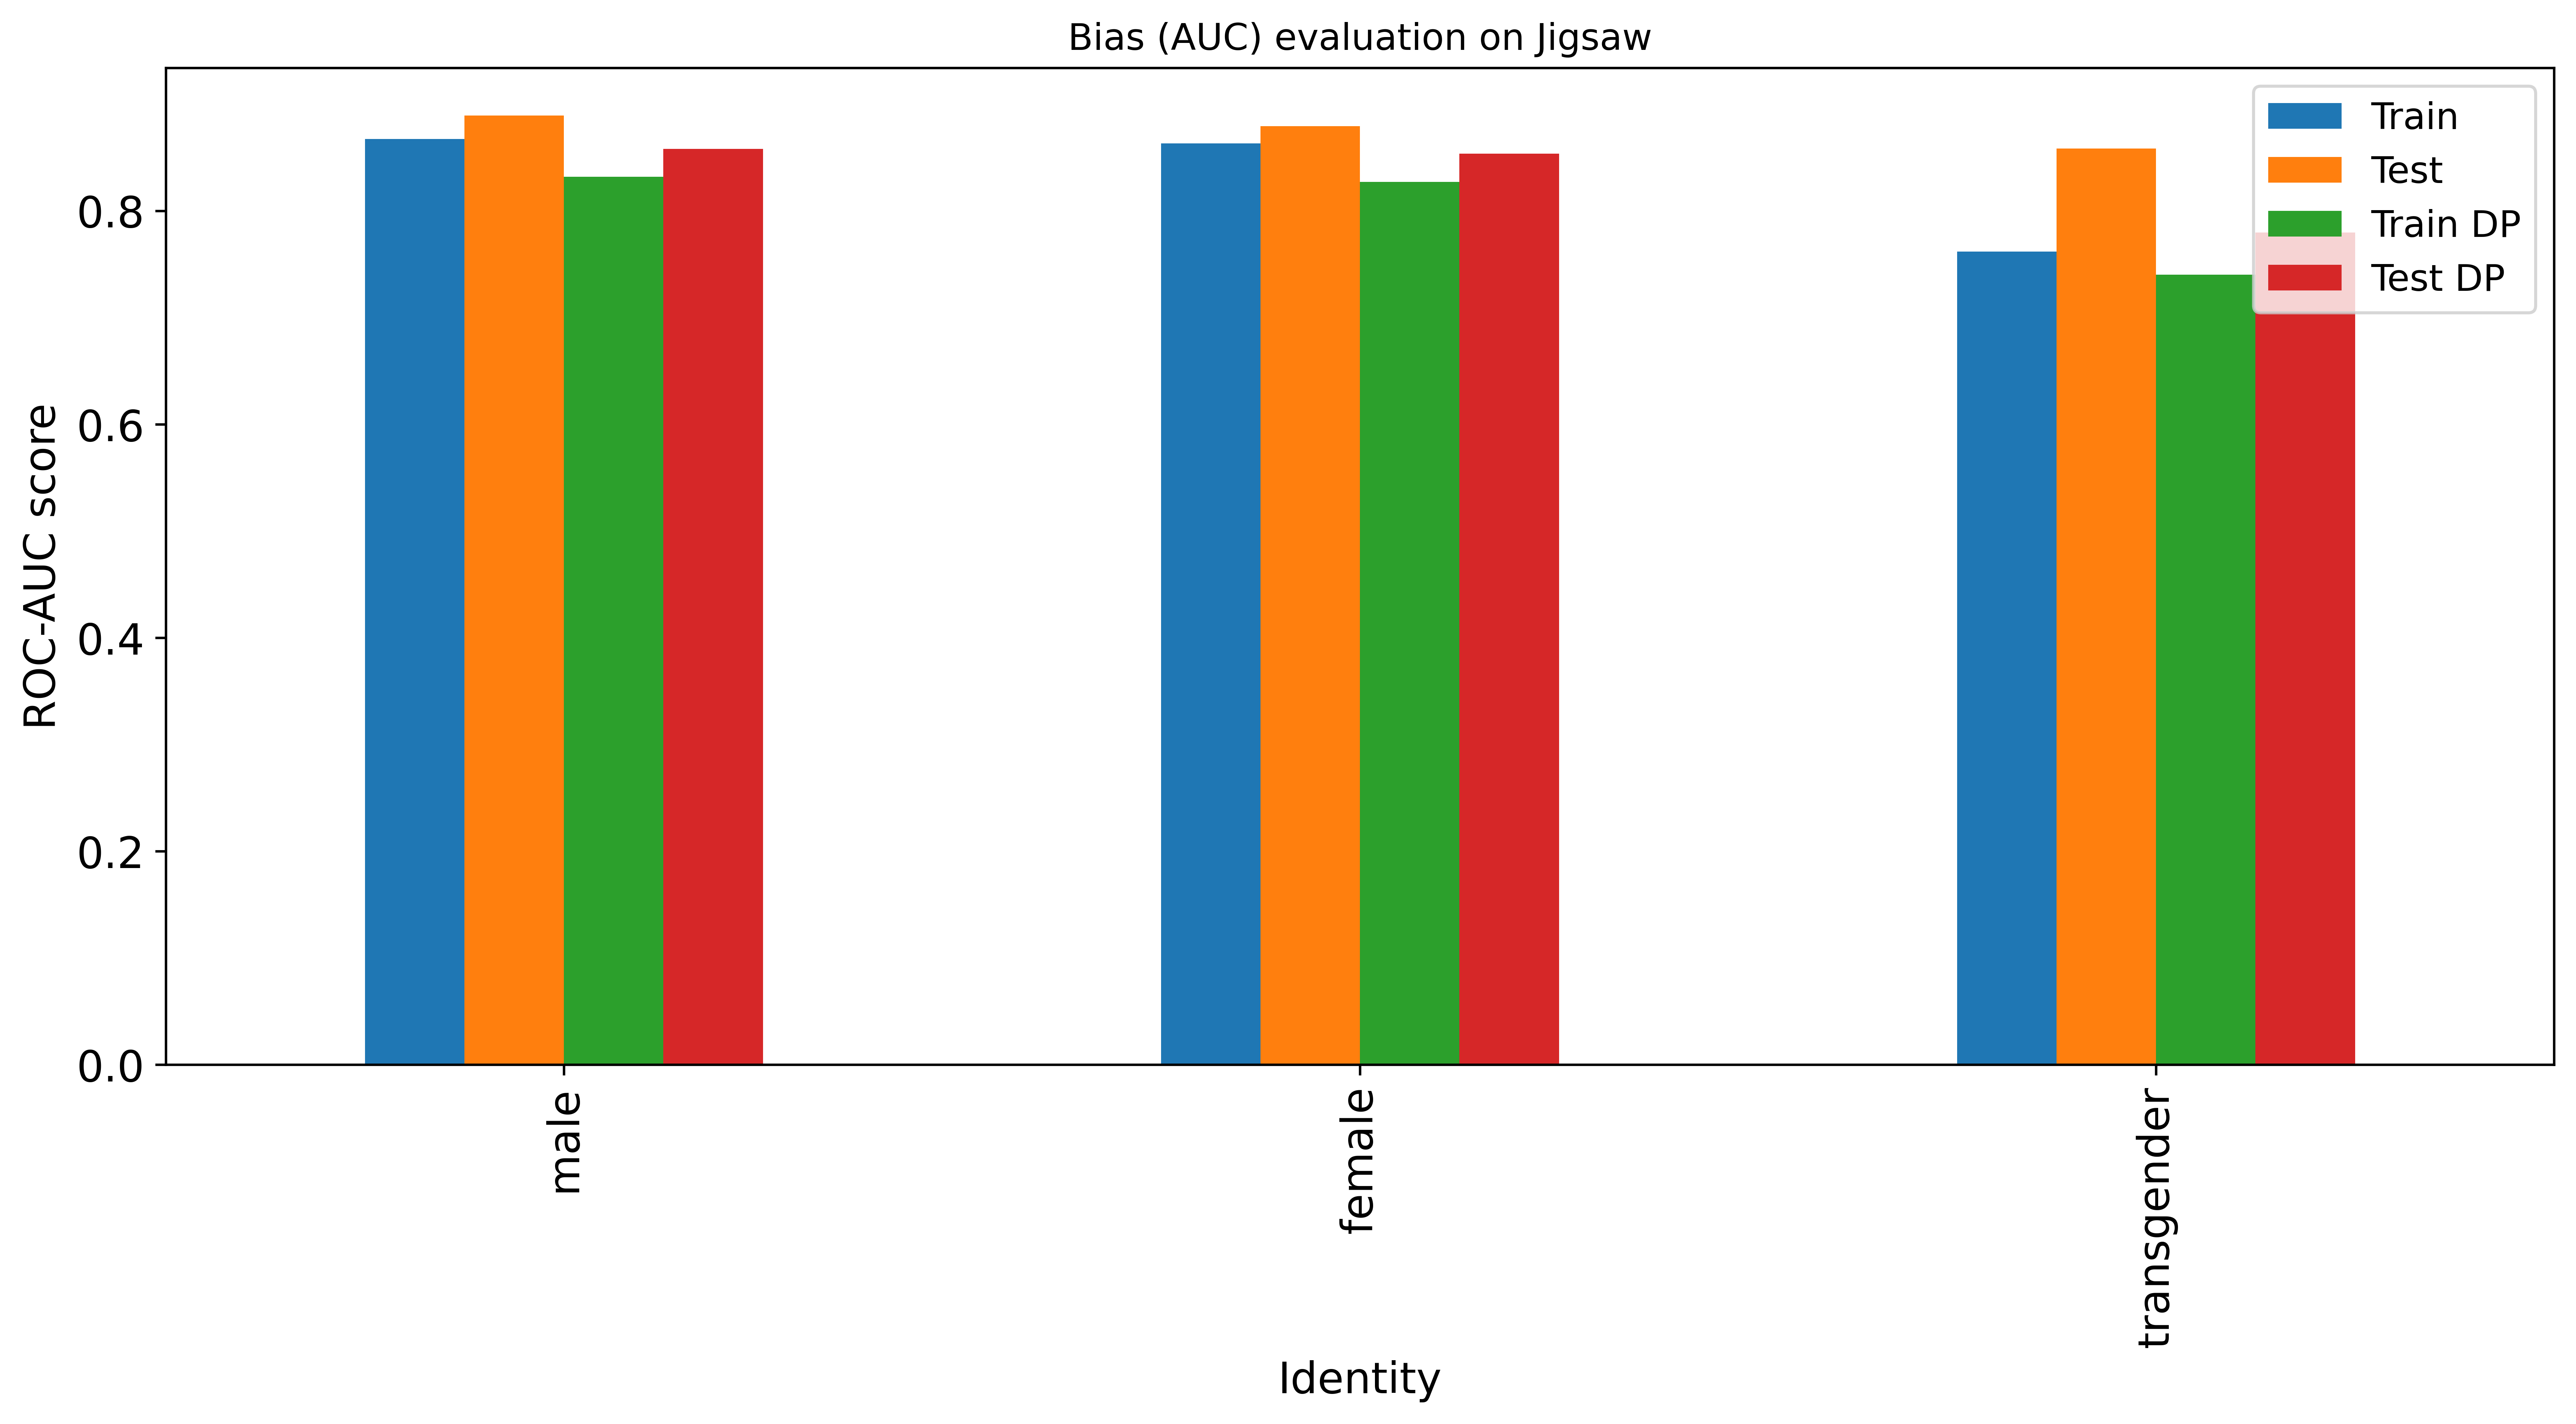

In [156]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Train': train_bias_metrics_df[SUBGROUP_AUC],
        'Test': test_bias_metrics_df[SUBGROUP_AUC],
        'Train DP': train_dp_bias_metrics_df[SUBGROUP_AUC],
        'Test DP': test_dp_bias_metrics_df[SUBGROUP_AUC]
    }
)

# plot grouped bar chart
ax = plot_df.plot(
        x='Identity',
        kind='bar',
        stacked=False,
        title='Bias (AUC) evaluation on Jigsaw',
        figsize=(14, 6),
        fontsize=14
)

ax.set_xlabel('Identity', fontsize=14)
ax.set_ylabel('ROC-AUC score', fontsize=14)
ax.legend(loc=1, fontsize=12)
plt.savefig(os.path.join(results_root, 'AUC_plot.svg'))

## F1-score

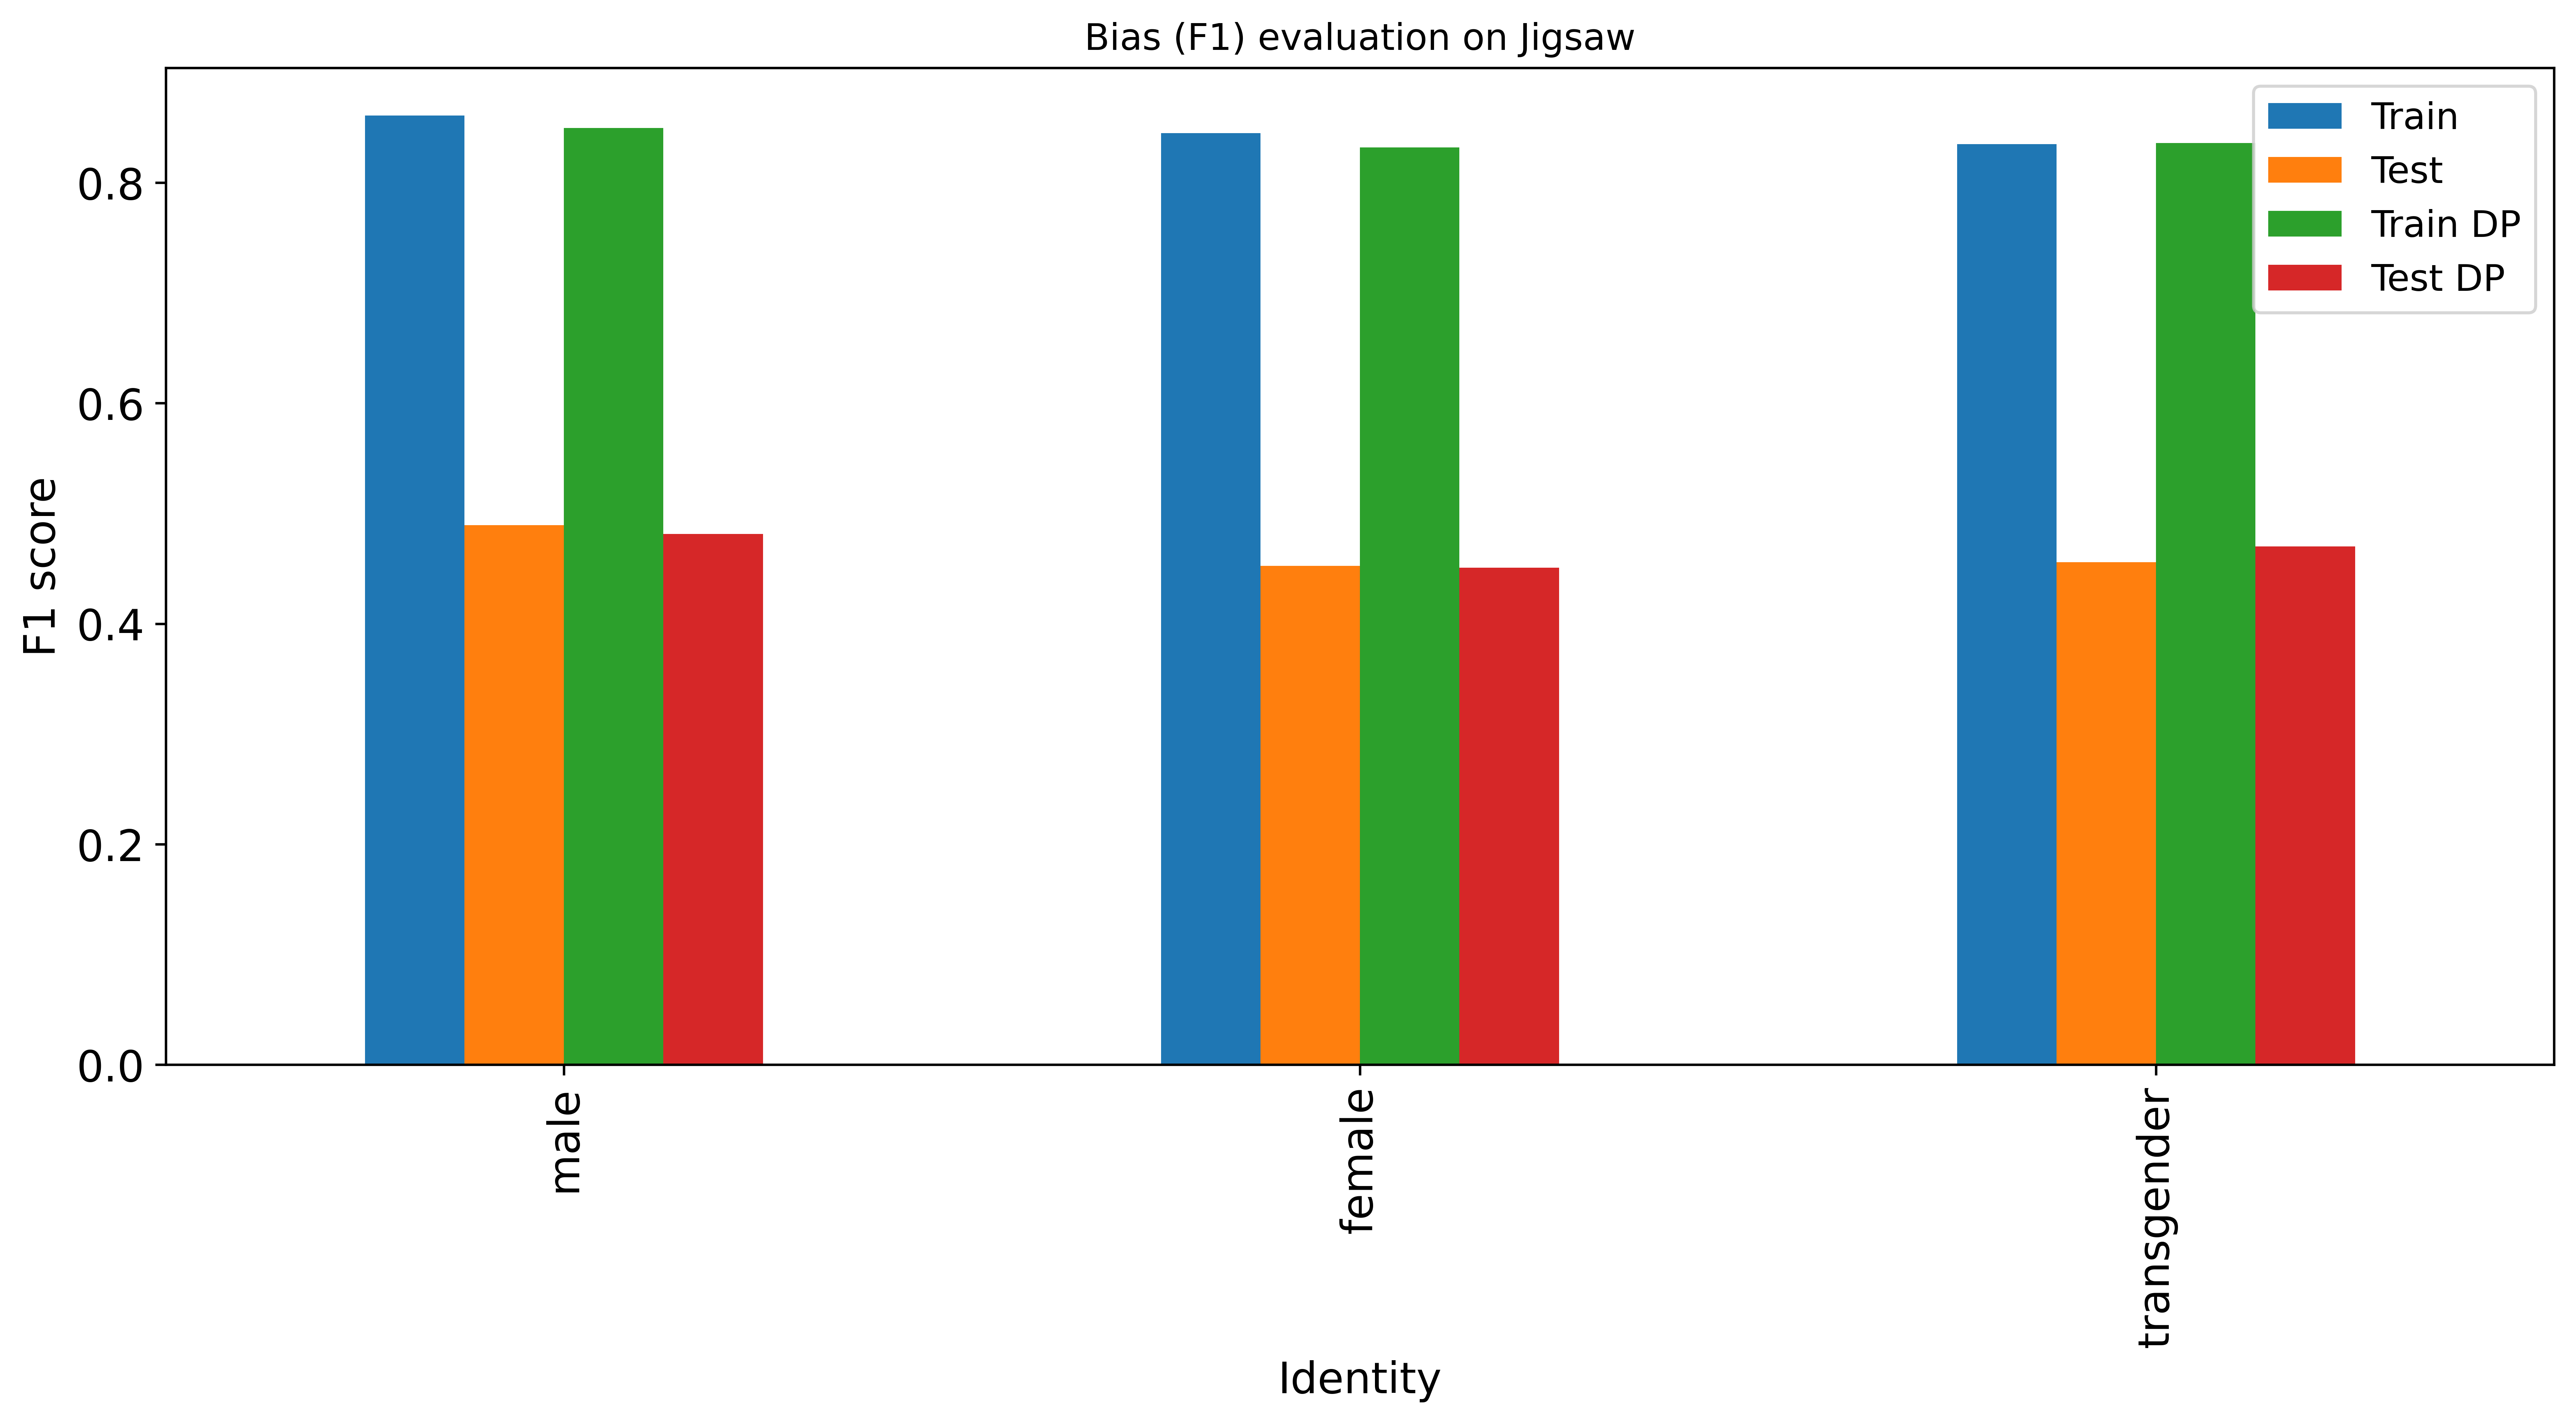

In [157]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Train': train_bias_metrics_df[SUBGROUP_F1],
        'Test': test_bias_metrics_df[SUBGROUP_F1],
        'Train DP': train_dp_bias_metrics_df[SUBGROUP_F1],
        'Test DP': test_dp_bias_metrics_df[SUBGROUP_F1]
    }
)

# plot grouped bar chart
ax = plot_df.plot(
        x='Identity',
        kind='bar',
        stacked=False,
        title='Bias (F1) evaluation on Jigsaw',
        figsize=(14, 6),
        fontsize=14
)

ax.set_xlabel('Identity', fontsize=14)
ax.set_ylabel('F1 score', fontsize=14)
ax.legend(loc=1, fontsize=12)
plt.savefig(os.path.join(results_root, 'F1_plot.svg'))

## False Positive Rate

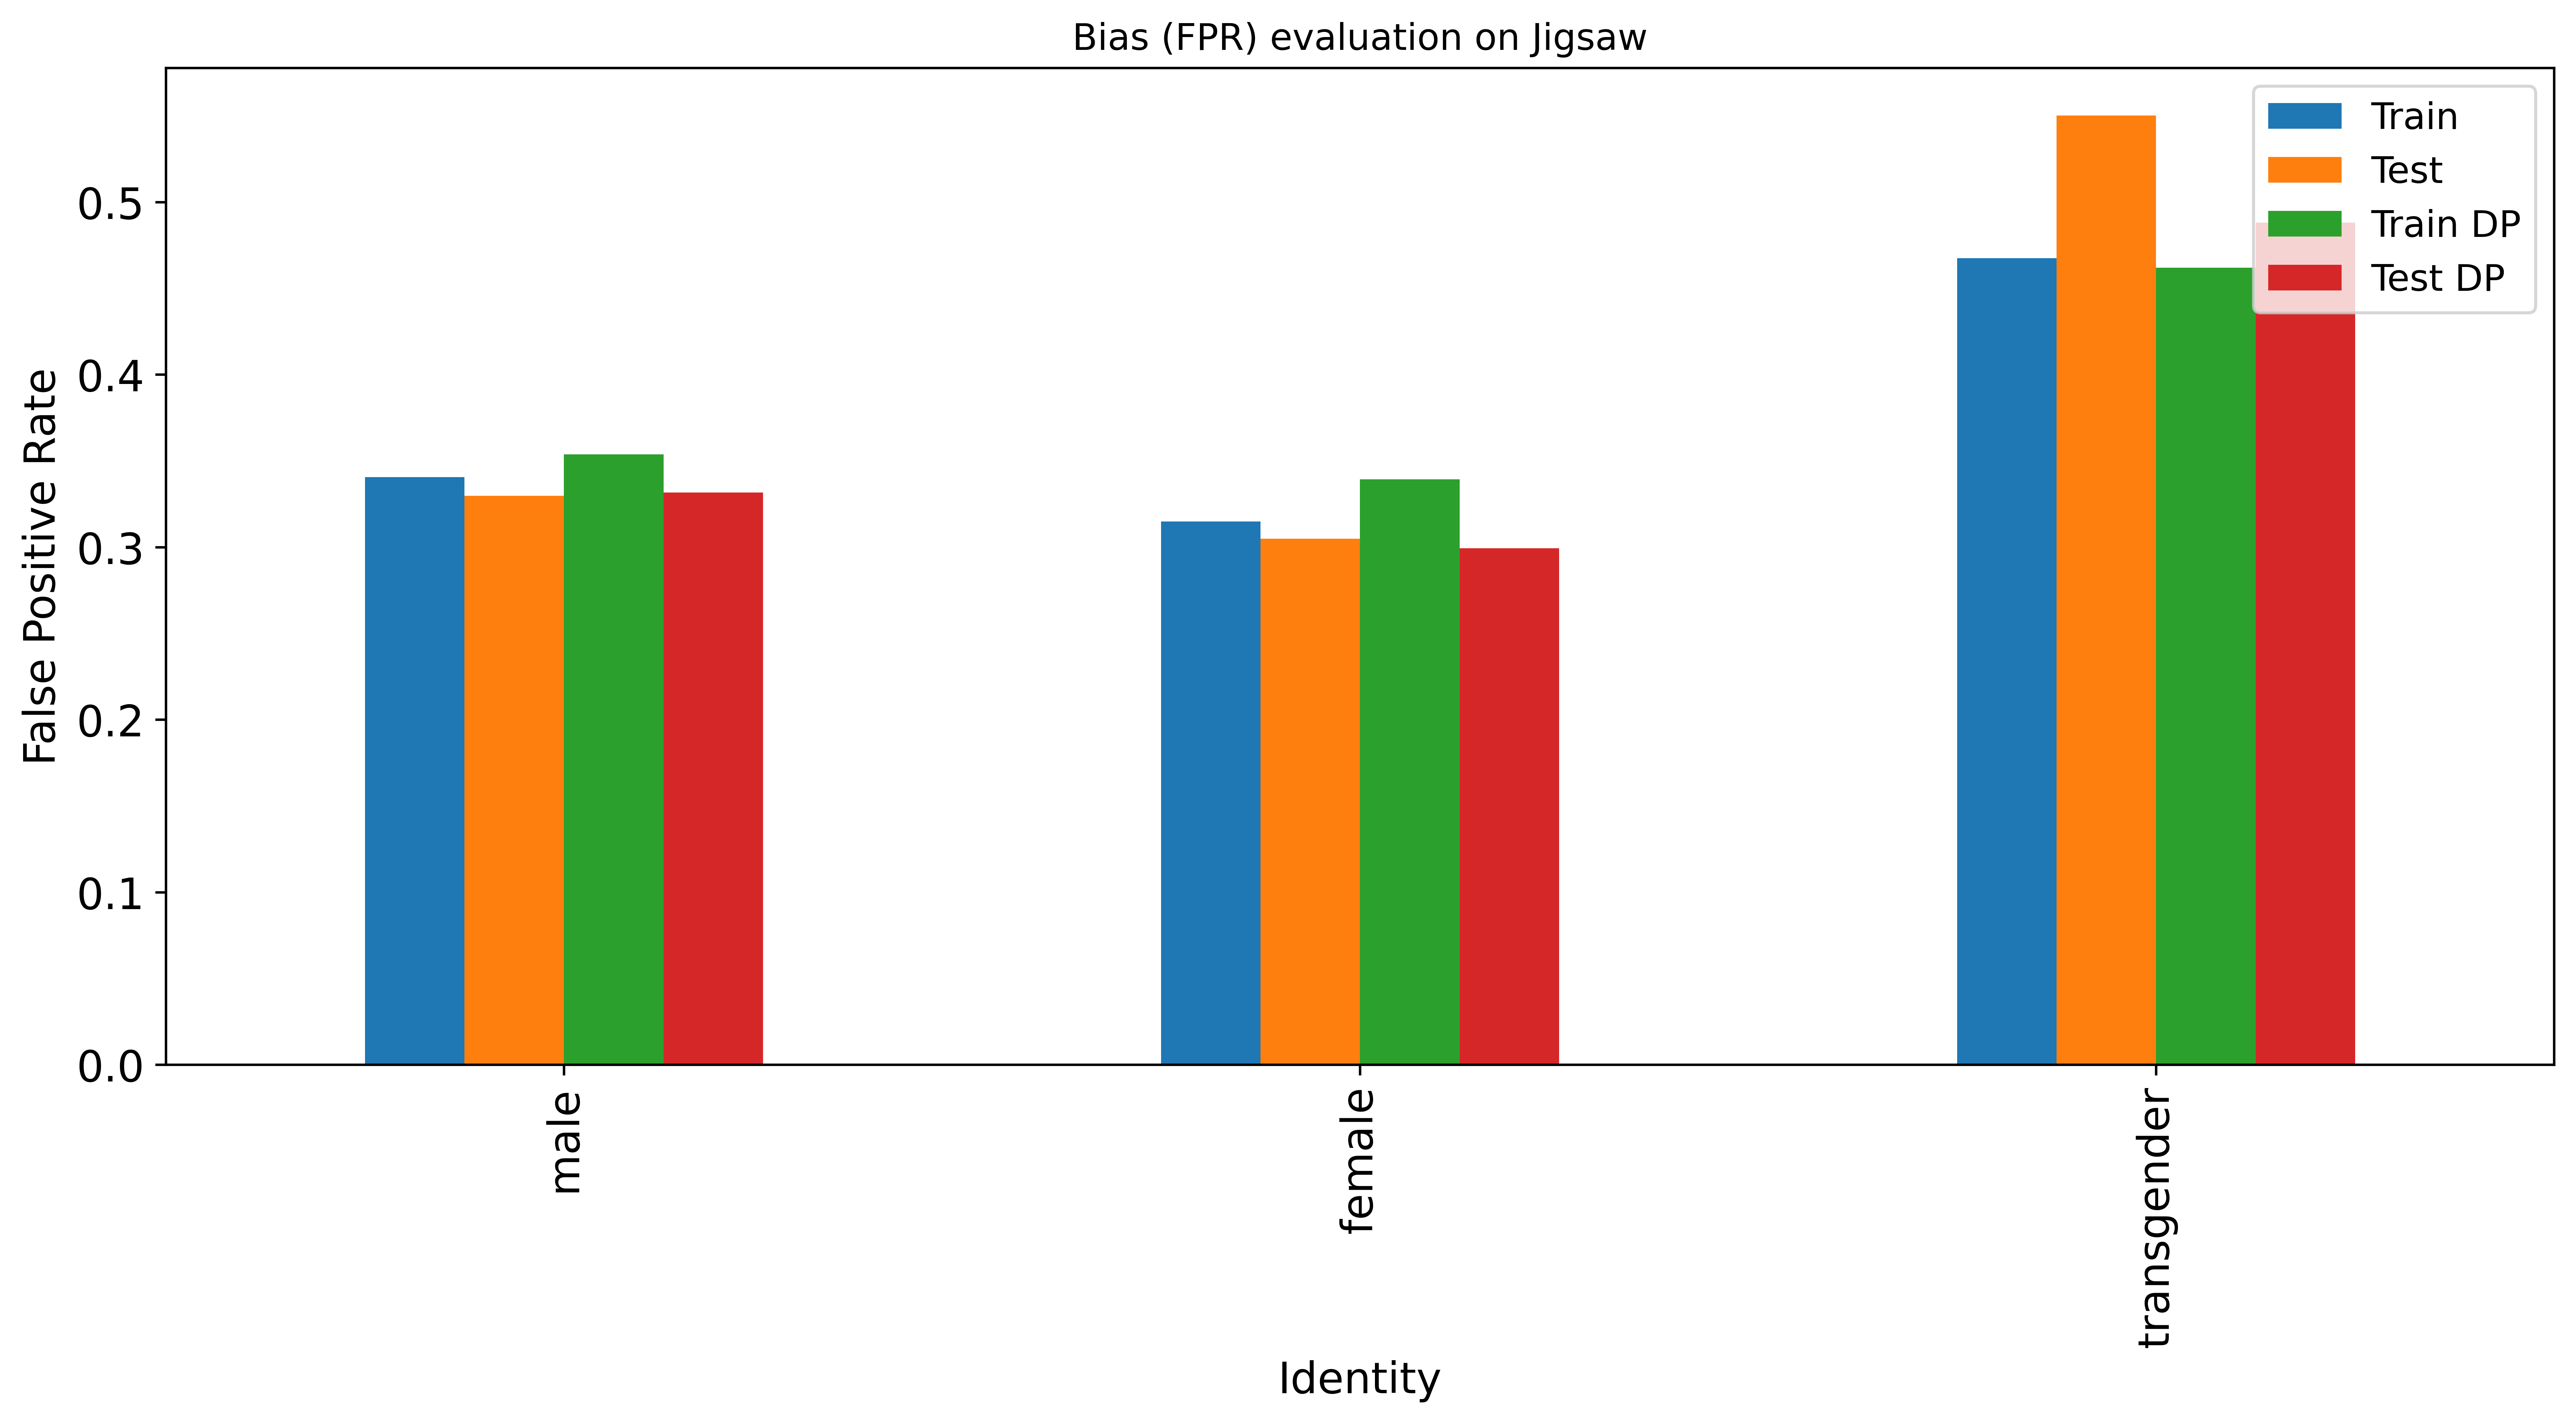

In [158]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Train': train_bias_metrics_df[SUBGROUP_FPR],
        'Test': test_bias_metrics_df[SUBGROUP_FPR],
        'Train DP': train_dp_bias_metrics_df[SUBGROUP_FPR],
        'Test DP': test_dp_bias_metrics_df[SUBGROUP_FPR]
    }
)

# plot grouped bar chart
ax = plot_df.plot(
        x='Identity',
        kind='bar',
        stacked=False,
        title='Bias (FPR) evaluation on Jigsaw',
        figsize=(14, 6),
        fontsize=14
)

ax.set_xlabel('Identity', fontsize=14)
ax.set_ylabel('False Positive Rate', fontsize=14)
ax.legend(loc=1, fontsize=12)
plt.savefig(os.path.join(results_root, 'FPR_plot.svg'))

## BPSN

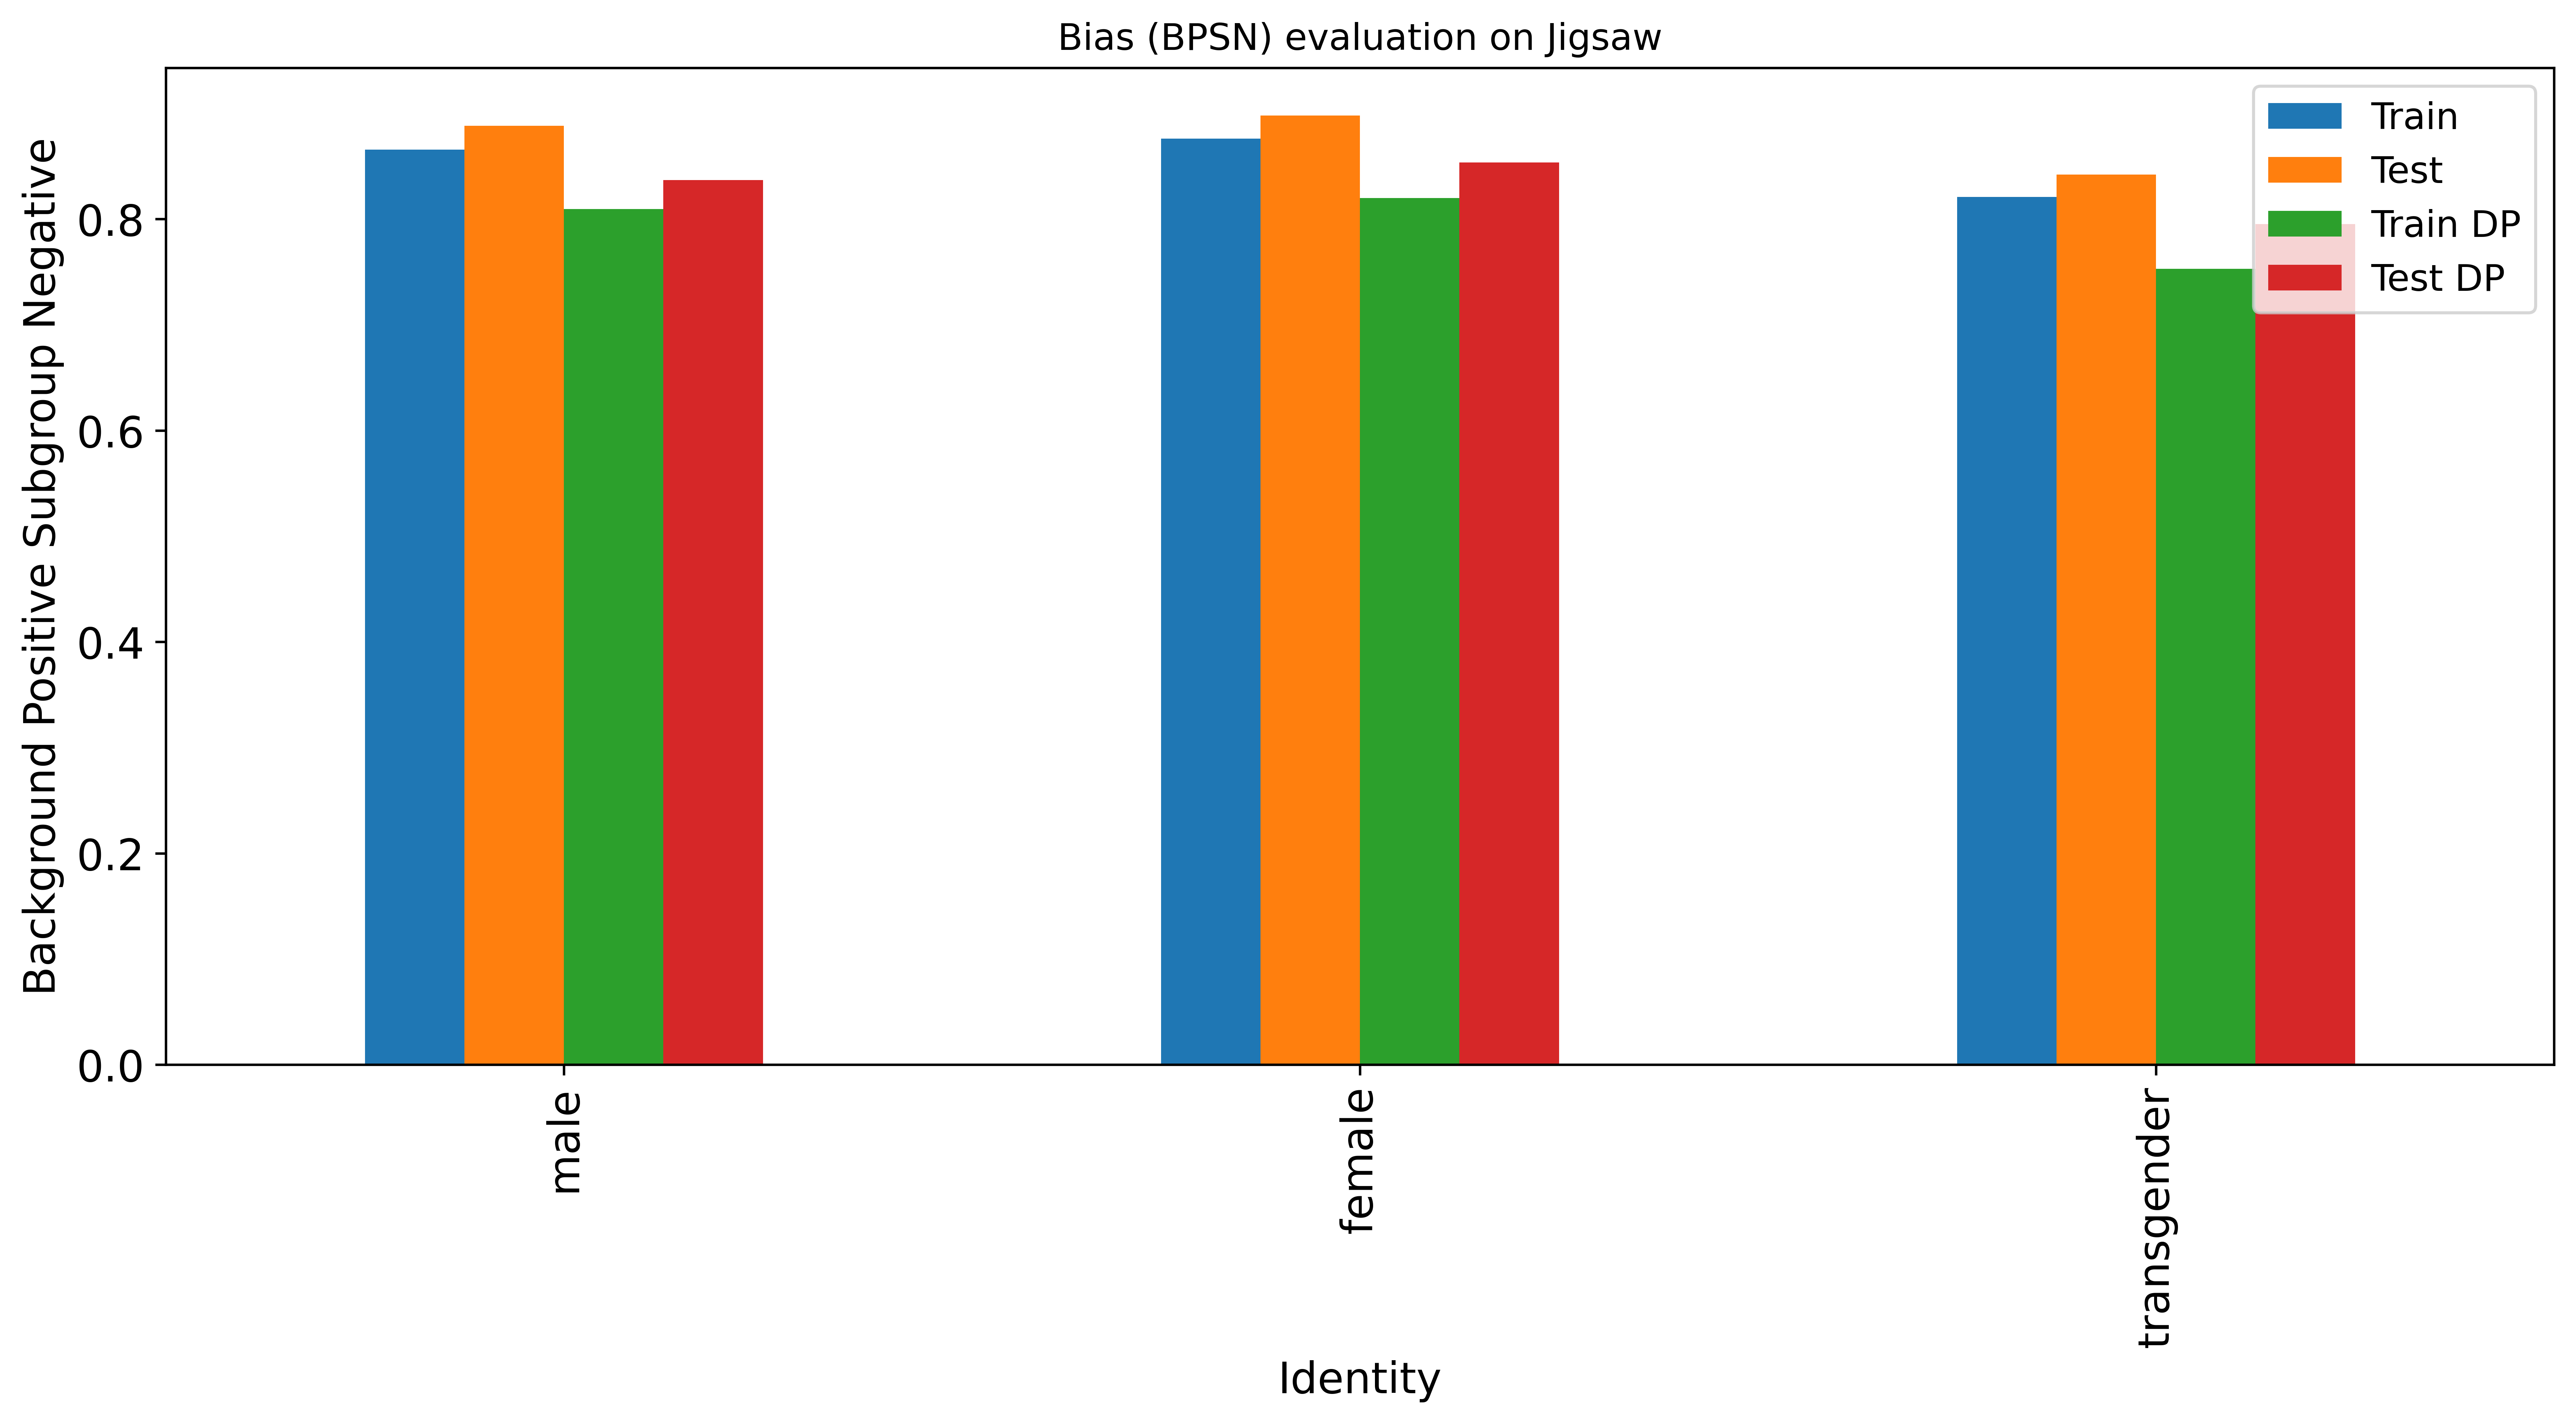

In [159]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Train': train_bias_metrics_df[BPSN_AUC],
        'Test': test_bias_metrics_df[BPSN_AUC],
        'Train DP': train_dp_bias_metrics_df[BPSN_AUC],
        'Test DP': test_dp_bias_metrics_df[BPSN_AUC]
    }
)

# plot grouped bar chart
ax = plot_df.plot(
        x='Identity',
        kind='bar',
        stacked=False,
        title='Bias (BPSN) evaluation on Jigsaw',
        figsize=(14, 6),
        fontsize=14
)

ax.set_xlabel('Identity', fontsize=14)
ax.set_ylabel('Background Positive Subgroup Negative', fontsize=14)
ax.legend(loc=1, fontsize=12)
plt.savefig(os.path.join(results_root, 'BPSN_plot.svg'))